In [8]:
# -*- coding: utf-8 -*-
'''
This script retrieves twitter and Binance data and write it into input_path(default: "input/data.csv") every minute (t min 04 sec);
then it waits spark to output the prediction into output_path(default: "output/data.csv"), where the prediction column name should be "close";
then it plots the close price in the past 60 minutes and the predicted future close price in 5 minutes every minute.
Adjustable parameters:
input_path(="input/data.csv"): where this script wrtites twitter and Binance data
output_path(="output/data.csv"): where spark writes predicted price
wait(=5): the seconds needed for spark to predict
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
from tqdm import tnrange, tqdm_notebook, tqdm
import nltk
try:
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
except:
    nltk.download('vader_lexicon')
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import json
import os
import random
import subprocess
import time
from datetime import date, datetime, timedelta
import requests

from time import sleep
import io

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")


'''Part2 Price'''
API_BASE = 'https://api.binance.com/api/v3/'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def set_dtypes(df):
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    # df = df.set_index('open_time', drop=True)
    print(df.columns)

    df = df.astype(dtype={
        'open': 'float64',
        'high': 'float64',
        'low': 'float64',
        'close': 'float64',
        'volume': 'float64',
        'quote_asset_volume': 'float64',
        'number_of_trades': 'int64',
        'taker_buy_base_asset_volume': 'float64',
        'taker_buy_quote_asset_volume': 'float64'
        # 'ignore': 'float64'
    })
    return df


def quick_clean(df):
    # drop dupes
    dupes = df['open_time'].duplicated().sum()
    if dupes > 0:
        df = df[df['open_time'].duplicated() == False]

    # sort by timestamp, oldest first
    df.sort_values(by=['open_time'], ascending=False)

    df.drop(['close_time', 'ignore'], axis=1, inplace=True)

    return df


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.ConnectionResetError:
        print('Connection reset by peer, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    print(f'Got erroneous response back: {response}')
    return pd.DataFrame([])


def ExtractPrice(t):
    base = 'BTC'
    quote = 'BUSD'
    t = time.strptime(t, '%Y-%m-%d %H:%M:%S')
    timeStamp = int(time.mktime(t)) * 1000

    new_batch = get_batch(symbol=base + quote,
                          interval='1m',
                          start_time=timeStamp)
    new_batch = quick_clean(new_batch)
    new_batch = set_dtypes(new_batch)
    return new_batch


'''Part3 Preprocess'''


def Preprocess(t):
    #tweets_raw_file = ExtractTwitter(t)
    tweets_raw_file = pd.read_parquet('twitter_score/', engine='pyarrow')
    tweets_df = tweets_raw_file[['end_time','score','weighted_score']]\
        .rename(columns={'end_time': 'open_time',
                 'score': 'avg', 
                 'weighted_score': 'wgtavg'})
    pricedf = ExtractPrice(t)
    pricedf = pricedf.iloc[-60:,:]
    data = pd.merge(tweets_df, pricedf, how='right', on='open_time').fillna({'avg': 0.0, 'wgtavg': 0.0})
#     print(data.head(20))
    return data


'''#Part4 Plot Prediction'''
def plot_price(data, output_list, fig, wait):
    plt.pause(wait)
    #print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    plt.clf()
    plt.plot(np.arange(-59,1,1),data['close'],label='Past price')
    plt.plot(np.arange(1,6),output_list,'y--',label='Future price prediction')
    plt.xticks(np.arange(-60, 6, 5))
    plt.xlabel('Time (minutes from now)')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    fig.canvas.flush_events()
    #print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
    plt.pause(10)

In [9]:
import sklearn
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib

class Model3(nn.Module):

    def __init__(self, hidden_dim=128):
        super(Model3, self).__init__()
        self.lstm = nn.LSTM(input_size=6, hidden_size=hidden_dim, num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        self.fn = nn.Linear(hidden_dim*2, 4)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batchsize, max_len, emb_dim = x.shape
        output, (h, c) = self.lstm(x)
        output = self.relu(output[:,-5:,:])
        output = self.fn(output)

        return output

class LSTM_Module(nn.Module):

    def __init__(self):
        super(LSTM_Module, self).__init__()
        pretrain = torch.load("deeplearning/parameters_twt.pt")
        self.scalar = pretrain["scalar"]
        self.model = pretrain["model_params"]

    def predict(self, inputs):
        # inputs: 1-D List[60*12]
        inputs = [inputs[i] for i in range(len(inputs)) if i % 12 != 0]
        inputs = np.array(inputs, dtype=np.float32).reshape(60, 11)
        inputs[:, 2] = self.scalar.transform(inputs[:, 2].reshape(-1, 1)).flatten()
        inputs[:, 3] = self.scalar.transform(inputs[:, 3].reshape(-1, 1)).flatten()
        inputs[:, 4] = self.scalar.transform(inputs[:, 4].reshape(-1, 1)).flatten()
        inputs[:, 5] = self.scalar.transform(inputs[:, 5].reshape(-1, 1)).flatten()
        x = (torch.tensor(inputs, dtype=torch.float32).unsqueeze(0))[:, :, :6]    # (1, 60, 6)
        
        self.model.eval()
        outputs = self.model(x)  # (1, 5, 4)
        output = self.scalar.inverse_transform(outputs[:, :, -1].detach().numpy())  # next five minutes, only output close (1, 5)
        return output.flatten().tolist()
    
class ScaledDotProductAttention(nn.Module):
    def __init__(self, attn_dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, Q, K, V):
        attn = F.softmax(torch.matmul(Q, K.permute(0, 2, 1)) / (K.shape[1] ** 0.5), dim=-1)
        # attn = self.dropout(attn)
        output = torch.matmul(attn, V)
        return output, attn

class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, input_dim, hidden_size=128, dropout=0.1):
        super().__init__()
        self.n_head = n_head
        self.input_dim = input_dim

        self.w_Q = nn.Linear(input_dim, hidden_size*2, bias=False)
        self.w_K = nn.Linear(input_dim, hidden_size*2, bias=False)
        self.w_V = nn.Linear(input_dim, hidden_size*2, bias=False)
        self.attention = ScaledDotProductAttention()
        self.ln = nn.LayerNorm(hidden_size*2, eps=1e-6)
        self.fn = nn.Linear(hidden_size*2, hidden_size*2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        # input: (B, length, d1)
        Q = self.w_Q(inputs)
        K = self.w_K(inputs)
        V = self.w_V(inputs)
        lst = []
        feat_dim = V.shape[2] // self.n_head

        for i in range(self.n_head):
            out, att = self.attention(Q[:, :, (i*feat_dim):((i+1)*feat_dim)],
                                      K[:, :, (i*feat_dim):((i+1)*feat_dim)],
                                      V[:, :, (i*feat_dim):((i+1)*feat_dim)])
            lst.append(out)
        output = torch.cat(lst, dim=-1)
        output = self.fn(output)
        output = self.ln(inputs + output)

        return output

class Model4(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Model4, self).__init__()

        self.lstm = nn.LSTM(input_size=6, hidden_size=hidden_dim, num_layers=1, batch_first=True, bidirectional=True, dropout=0.2)
        self.transformer_encoder_layer1 = MultiHeadAttention(n_head=2, input_dim=hidden_dim*2)
        self.transformer_encoder_layer2 = MultiHeadAttention(n_head=2, input_dim=hidden_dim*2)

        self.fn = nn.Linear(hidden_dim*2, 4)
        self.relu = nn.ReLU()


    def forward(self, x):
        x, (hn, cn) = self.lstm(x)  # (B, length, hidden_size*2)

        x = self.transformer_encoder_layer1(x)
        # x = self.transformer_encoder_layer2(x)
        output = self.relu(x[:,-5:,:])
        output = self.fn(output)
        return output


class Transformer_Module(nn.Module):
    def __init__(self):
        super(Transformer_Module, self).__init__()
        pretrain = torch.load("deeplearning/transformer_twt.pt")
        self.scalar = pretrain["scalar"]
        self.model = pretrain["model_params"]

    def predict(self, inputs):
        # inputs: 1-D List[60*12]
        inputs = [inputs[i] for i in range(len(inputs)) if i % 12 != 0]
        inputs = np.array(inputs, dtype=np.float32).reshape(60, 11)
        inputs[:, 2] = self.scalar.transform(inputs[:, 2].reshape(-1, 1)).flatten()
        inputs[:, 3] = self.scalar.transform(inputs[:, 3].reshape(-1, 1)).flatten()
        inputs[:, 4] = self.scalar.transform(inputs[:, 4].reshape(-1, 1)).flatten()
        inputs[:, 5] = self.scalar.transform(inputs[:, 5].reshape(-1, 1)).flatten()
        x = (torch.tensor(inputs, dtype=torch.float32).unsqueeze(0))[:, :, :6]  # (1, 60, 6)

        self.model.eval()
        outputs = self.model(x)  # (1, 5, 4)
        output = self.scalar.inverse_transform(
            outputs[:, :, -1].detach().numpy())  # next five minutes, only output close (1, 5)
        return output.flatten().tolist()

    
class GBDT_Module():
    def __init__(self, model_root_path: str, max_pred_pength: int = 5):
        """
        Initialization

        :param model_root_path: the root path that stores models
        :param max_pred_pength: the maximum length we want to predict
        """

        self.m = max_pred_pength
        self.model_list = list()
        if not model_root_path.endswith("/"): model_root_path = model_root_path + "/"

        for i in range(1, self.m + 1):
            model_full_path = model_root_path + "gbdt_" + str(i) + "_minutes_later.pkl"
            # See if the model exist, if not, stop searching
            if not os.path.exists(model_full_path):
                print("[Warning]: Cannot find model with predict length %d, further searches are ignored." % i)
                break
            # If exists, add the model to the model list
            self.model_list.append(joblib.load(model_full_path))

    def predict2(self, history_data: list) -> list:
        """
        Predict close price 1~5 minutes in future

        :param history_data: values in the past hour, its length is 720, containing 60 samples as each sample has 12 features, the features are
                                [open_time, wgtavg, avg, open, high, low, close, volume, quote_asset_volume,
                                number_of_trades, taker_buy_base_asset_volume, taker_buy_quote_asset_volume]
        :return: a list with size 5, value at index 0 represents price 1min later, value at index 1 represents price 2mins later...
        """
        history_data_array = np.asarray(history_data).reshape(-1, 12)
        weights = [(self.m - i) / np.sum(np.arange(self.m + 1)) for i in range(self.m)]
        price_pred = []

        for i in range(self.m):
            cur_sum, cur_portion = 0, 0
            for j in range(self.m):
                if j + self.m - i > 0:
                    cur_sum += weights[j] * (self.model_list[j].predict(
                        history_data_array[-((j + self.m) - i), 1:].reshape(1, -1))[0] +
                                             float(history_data_array[-((j + self.m) - i)][6]))
                    cur_portion += weights[j]
            price_pred.append(cur_sum / cur_portion if cur_portion != 0 else 0)

        return price_pred

gbdt model loaded
lstm model loaded
feature collection latency: 0.000 sec
gbdt latency: 0.036 sec
lstm latency: 0.033 sec
total latency: 0.069 sec


<Figure size 720x432 with 0 Axes>

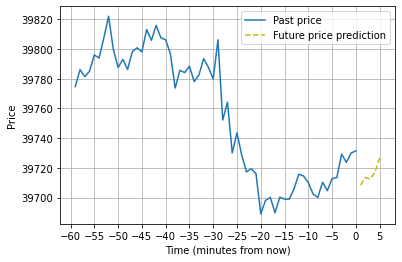

KeyboardInterrupt: 

In [11]:
"""# Part5 Data Streaming"""
if __name__=='__main__':
    input_path = 'input/data.csv'
    output_path = 'output/data.csv'
    wait=1
    
    plt.ion()
    fig=plt.figure(num=1,figsize=(10,6))
    
    gbdt = GBDT_Module(model_root_path='MachineLearning/Models/')
    print('gbdt model loaded')
    
    lstm = LSTM_Module()
    print('lstm model loaded')
    
    transformer = Transformer_Module()
    print('transformer model loaded')
    while True:
        now=int(time.strftime('%S', time.localtime(time.time())))
        if now!=4:
            time.sleep(0.5)
            continue

        t = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time() - 60 * 60 - 8 * 60 * 60))
        
        start_timestamp = datetime.now()
        data = Preprocess(t)
        feature_collection_timestamp = datetime.now()
        print('feature collection latency: %.3f sec' % (feature_collection_timestamp-start_timestamp).total_seconds())
        data.to_csv(input_path, index=False) # can deprecate

        # TODO: model prediction
#         data = pd.read_csv('input/data.csv') # uncomment for offline test
        input_list = data.to_numpy().flatten().tolist()
        # 1. gbdt
        # output_gbdt: [t1, t2, t3, t4, t5]
        output_gbdt = gbdt.predict2(input_list)

        
#         output_gbdt = [39680.7, 39680.7, 39680.7, 39680.7, 39680.7] #sample
         
        gbdt_timestamp = datetime.now()
        print('gbdt latency: %.3f sec' % (gbdt_timestamp-feature_collection_timestamp).total_seconds())
        
        #2. lstm
        # output_lstm: [t1, t2, t3, t4, t5]
        output_lstm = lstm.predict(input_list)
        
        
        # output_lstm = [39680.7, 39680.7, 39680.7, 39680.7, 39680.7]
        
        lstm_timestamp = datetime.now()
        print('lstm latency: %.3f sec' % (lstm_timestamp-gbdt_timestamp).total_seconds())
        
        # 3. transformer
        output_transformer = transformer.predict(input_list)
        transformer_timestamp = datetime.now()
        print('transformer latency: %.3f sec' % (transformer_timestamp-lstm_timestamp).total_seconds())
        
        print('total latency: %.3f sec' % (transformer_timestamp-start_timestamp).total_seconds())
        
        w_gbdt = 0.5
        w_lstm = 1 - w_gbdt
        final_output = [w_gbdt * output_gbdt[i]  + w_lstm * output_lstm[i] for i in range(5)]
        
        plot_price(data,final_output,fig,wait)